In [25]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns; sns.set()
import pandas as pd
import numpy as np
import copy
from sklearn.utils import resample
from sklearn.preprocessing import scale, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import log_loss, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

train_values = np.loadtxt("train_values.csv", delimiter=",", dtype=object)
train_labels = np.loadtxt("train_labels.csv", delimiter=",", dtype=object)

d = np.empty(15, dtype=object)

d[0],d[1],d[2],d[3],d[4],d[5],d[6],d[7],d[8],d[9],d[10],d[11],d[12],d[13] = np.hsplit(train_values, 14)
d[0],d[14] = np.hsplit(train_labels, 2)

atributes = {}

for n,obj in enumerate(d):
    atributes[n] = obj[0][0]
    d[n] = np.squeeze(d[n])[1:]

#NOTE: the columns lable in pd.df is numeric. For a given column N, its property corresponds to atributes[N+1]
data = pd.DataFrame(data=d[1],index=d[0])
for n in range(15):
    if n < 2:
        continue
    data[n-1] = d[n]

#### The 14 features are describedbelow:

- slope_of_peak_exercise_st_segment (type: int): the slope of the peak exercise ST segment, an electrocardiography read out indicating quality of blood flow to the heart
- thal (type: categorical): results of thallium stress test measuring blood flow to the heart, with possible values normal, fixed_defect, reversible_defect
- resting_blood_pressure (type: int): resting blood pressure
- chest_pain_type (type: int): chest pain type (4 values)
- num_major_vessels (type: int): number of major vessels (0-3) colored by flourosopy
- fasting_blood_sugar_gt_120_mg_per_dl (type: binary): fasting blood sugar > 120 mg/dl
- resting_ekg_results (type: int): resting electrocardiographic results (values 0,1,2)
- serum_cholesterol_mg_per_dl (type: int): serum cholestoral in mg/dl
- oldpeak_eq_st_depression (type: float): oldpeak = ST depression induced by exercise relative to rest, a measure of abnormality in electrocardiograms
- sex (type: binary): 0: female, 1: male
- age (type: int): age in years
- max_heart_rate_achieved (type: int): maximum heart rate achieved (beats per minute)
- exercise_induced_angina (type: binary): exercise-induced chest pain (0: False, 1: True)
- heart_disease_present (type: binary): 0: heart disease not present, 1: heart disease present 

NOTE: The index in data corresponds to patient ID

In [26]:
print(atributes)
data.head()

{0: 'patient_id', 1: 'slope_of_peak_exercise_st_segment', 2: 'thal', 3: 'resting_blood_pressure', 4: 'chest_pain_type', 5: 'num_major_vessels', 6: 'fasting_blood_sugar_gt_120_mg_per_dl', 7: 'resting_ekg_results', 8: 'serum_cholesterol_mg_per_dl', 9: 'oldpeak_eq_st_depression', 10: 'sex', 11: 'age', 12: 'max_heart_rate_achieved', 13: 'exercise_induced_angina', 14: 'heart_disease_present'}


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0,0
ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0,0
yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1,1
l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0,1
oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0,0


In [27]:
# Counts for heart_disease_present in training data
data[13].value_counts()

0    100
1     80
Name: 13, dtype: int64

In [28]:
data = (data.astype({0: 'float64', 1: 'category', 2: 'float64', 3: 'float64', 4: 'float64', 5: 'float64', 6: 'float64', 7: 'float64',
                    8: 'float64', 9: 'float64', 10: 'float64', 11: 'float64', 12: 'float64', 13: 'int64'}))
print(data.dtypes)

# Average for each attribute whether or not heart_disease_present
data.groupby(13).mean()

0      float64
1     category
2      float64
3      float64
4      float64
5      float64
6      float64
7      float64
8      float64
9      float64
10     float64
11     float64
12     float64
13       int64
dtype: object


,0,2,3,4,5,6,7,8,9,10,11,12
13,,,,,,,,,,,,
0,1.3600,130.12,2.8100,0.33,0.1600,0.9200,245.46,0.62700,0.5500,53.66,156.87,0.13
1,1.7875,132.80,3.5875,1.15,0.1625,1.2125,253.90,1.48875,0.8625,56.25,140.25,0.55


In [29]:
category_col = data.select_dtypes(['category']).columns 
data[category_col] = data[category_col].apply(lambda x: x.cat.codes)
print(data.head())

         0   1      2    3    4    5    6      7    8    9     10     11   12  \
0z64un  1.0   1  128.0  2.0  0.0  0.0  2.0  308.0  0.0  1.0  45.0  170.0  0.0   
ryoo3j  2.0   1  110.0  3.0  0.0  0.0  0.0  214.0  1.6  0.0  54.0  158.0  0.0   
yt1s1x  1.0   1  125.0  4.0  3.0  0.0  2.0  304.0  0.0  1.0  77.0  162.0  1.0   
l2xjde  1.0   2  152.0  4.0  0.0  0.0  0.0  223.0  0.0  1.0  40.0  181.0  0.0   
oyt4ek  3.0   2  178.0  1.0  0.0  0.0  2.0  270.0  4.2  1.0  59.0  145.0  0.0   

        13  
0z64un   0  
ryoo3j   0  
yt1s1x   1  
l2xjde   1  
oyt4ek   0  


In [30]:
thal = {0:'fixed_defect', 1:'normal', 2:'reversible_defect'}
data.groupby(13).mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12
13,,,,,,,,,,,,,
0,1.3600,1.14,130.12,2.8100,0.33,0.1600,0.9200,245.46,0.62700,0.5500,53.66,156.87,0.13
1,1.7875,1.65,132.80,3.5875,1.15,0.1625,1.2125,253.90,1.48875,0.8625,56.25,140.25,0.55


In [31]:
X = data.loc[:, data.columns != 13]
y = np.array(data.loc[:, data.columns == 13]).reshape(180,)
print(X.head())
X.shape

         0   1      2    3    4    5    6      7    8    9     10     11   12
0z64un  1.0   1  128.0  2.0  0.0  0.0  2.0  308.0  0.0  1.0  45.0  170.0  0.0
ryoo3j  2.0   1  110.0  3.0  0.0  0.0  0.0  214.0  1.6  0.0  54.0  158.0  0.0
yt1s1x  1.0   1  125.0  4.0  3.0  0.0  2.0  304.0  0.0  1.0  77.0  162.0  1.0
l2xjde  1.0   2  152.0  4.0  0.0  0.0  0.0  223.0  0.0  1.0  40.0  181.0  0.0
oyt4ek  3.0   2  178.0  1.0  0.0  0.0  2.0  270.0  4.2  1.0  59.0  145.0  0.0


(180, 13)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_pred_prob = dt.predict_proba(X_test)

print(f'Accuracy of dt classifier on test set: {dt.score(X_test, y_test)}')
lloss = log_loss(y_test, dt_pred_prob)
print(f'log loss: {lloss}')

confMatrix = confusion_matrix(y_test, dt_pred)
print(confMatrix)
print(classification_report(y_test, dt_pred))

boosted_classifier = AdaBoostClassifier()
boosted_classifier.fit(X_train, y_train)
boosted_pred = boosted_classifier.predict(X_test)
boosted_pred_prob = boosted_classifier.predict_proba(X_test)

print(f'Accuracy of boosted classifier on test set: {boosted_classifier.score(X_test, y_test)}')
lloss = log_loss(y_test, boosted_pred_prob)
print(f'log loss: {lloss}')

confMatrix = confusion_matrix(y_test, boosted_pred)
print(confMatrix)
print(classification_report(y_test, boosted_pred))

Accuracy of dt classifier on test set: 0.7222222222222222
log loss: 9.594104554141857
[[16  8]
 [ 2 10]]
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        24
           1       0.56      0.83      0.67        12

   micro avg       0.72      0.72      0.72        36
   macro avg       0.72      0.75      0.71        36
weighted avg       0.78      0.72      0.73        36

Accuracy of boosted classifier on test set: 0.7777777777777778
log loss: 0.6473343837646569
[[17  7]
 [ 1 11]]
              precision    recall  f1-score   support

           0       0.94      0.71      0.81        24
           1       0.61      0.92      0.73        12

   micro avg       0.78      0.78      0.78        36
   macro avg       0.78      0.81      0.77        36
weighted avg       0.83      0.78      0.78        36



C:\Users\nilay\Anaconda3\envs\BE188\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[ True  True False  True  True  True False False  True  True False False
  True]
[1 1 3 1 1 1 2 6 1 1 4 5 1]
8
[0.72272278 0.72272278 0.71592609 0.7299567  0.75079606 0.75817171
 0.79956699 0.8206898  0.81331416 0.77134595 0.77134595 0.79232101
 0.77872763]


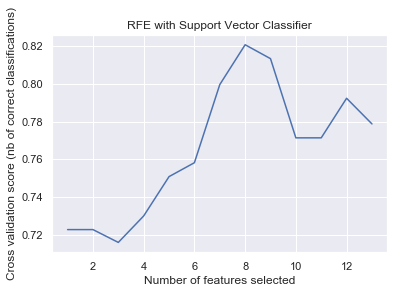

In [33]:
svclassifier = SVC(kernel='linear')  
rfe = RFECV(svclassifier)
rfe = rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)
print(rfe.n_features_)
print(rfe.grid_scores_)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.title("RFE with Support Vector Classifier")
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

In [34]:
for n, i in enumerate(rfe.support_):
    if i:
        print(atributes[n+1])
        
logregmask = [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1]
1, 3, 4, 6, 8, 9, 12 
print(f"\nWith LogReg Classififier:")
mainfeatures = []
for n, i in enumerate(logregmask):
    if not i:
        mainfeatures.append(n)
        continue;
    if not rfe.support_[n]:
        mainfeatures.append(n)
            
print(mainfeatures)
prim = [1,3,4,8,9,12,13]
data.head()

slope_of_peak_exercise_st_segment
thal
chest_pain_type
num_major_vessels
fasting_blood_sugar_gt_120_mg_per_dl
oldpeak_eq_st_depression
sex
exercise_induced_angina

With LogReg Classififier:
[0, 2, 5, 6, 7, 10, 11]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0z64un,1.0,1,128.0,2.0,0.0,0.0,2.0,308.0,0.0,1.0,45.0,170.0,0.0,0
ryoo3j,2.0,1,110.0,3.0,0.0,0.0,0.0,214.0,1.6,0.0,54.0,158.0,0.0,0
yt1s1x,1.0,1,125.0,4.0,3.0,0.0,2.0,304.0,0.0,1.0,77.0,162.0,1.0,1
l2xjde,1.0,2,152.0,4.0,0.0,0.0,0.0,223.0,0.0,1.0,40.0,181.0,0.0,1
oyt4ek,3.0,2,178.0,1.0,0.0,0.0,2.0,270.0,4.2,1.0,59.0,145.0,0.0,0


In [35]:
data6 = copy.deepcopy(data)
data6.drop(axis=1, labels=mainfeatures , inplace=True)
othfeat = [0,5,6]
data6.head()

,1,3,4,8,9,12,13
0z64un,1,2.0,0.0,0.0,1.0,0.0,0
ryoo3j,1,3.0,0.0,1.6,0.0,0.0,0
yt1s1x,1,4.0,3.0,0.0,1.0,1.0,1
l2xjde,2,4.0,0.0,0.0,1.0,0.0,1
oyt4ek,2,1.0,0.0,4.2,1.0,0.0,0


In [36]:
datan = [copy.deepcopy(data),copy.deepcopy(data),copy.deepcopy(data),copy.deepcopy(data),copy.deepcopy(data),copy.deepcopy(data),copy.deepcopy(data)]
templist = [0,5,6,[0,5],[0,6],[5,6],[0,5,6]]
fet = np.arange(0,13)

for n,itm in enumerate(templist):
    if (n == 0):
        mask = np.in1d(fet, [0]+prim, invert=True)
        datan[n].drop(axis=1, labels=fet[mask] , inplace=True)
    elif n == 1:
        mask = np.in1d(fet, [5]+prim, invert=True)

        datan[n].drop(axis=1, labels=fet[mask] , inplace=True)
    elif n == 2:
        mask = np.in1d(fet, [6]+prim, invert=True)

        datan[n].drop(axis=1, labels=fet[mask] , inplace=True)
    elif n == 3:
        mask = np.in1d(fet, [0,5]+prim, invert=True)

        datan[n].drop(axis=1, labels=fet[mask] , inplace=True)
    elif n == 4:
        mask = np.in1d(fet, [0,6]+prim, invert=True)

        datan[n].drop(axis=1, labels=fet[mask] , inplace=True)
    elif n == 5:
        mask = np.in1d(fet, [5,6]+prim, invert=True)

        datan[n].drop(axis=1, labels=fet[mask] , inplace=True)
    elif n == 6:
        mask = np.in1d(fet, [0,5,6]+prim, invert=True)

        datan[n].drop(axis=1, labels=fet[mask] , inplace=True)   
datan[1].head()

,1,3,4,5,8,9,12,13
0z64un,1,2.0,0.0,0.0,0.0,1.0,0.0,0
ryoo3j,1,3.0,0.0,0.0,1.6,0.0,0.0,0
yt1s1x,1,4.0,3.0,0.0,0.0,1.0,1.0,1
l2xjde,2,4.0,0.0,0.0,0.0,1.0,0.0,1
oyt4ek,2,1.0,0.0,0.0,4.2,1.0,0.0,0


In [37]:
datan.insert(0, data6)
datan = np.array(datan)
d = datan[1]
X = d.loc[:, d.columns != 13]
y = np.array(d.loc[:, d.columns == 13]).reshape(180,)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [38]:
pipe = Pipeline(steps=[('logistic', LogisticRegression(multi_class = 'multinomial', max_iter=10000))])
pipe

Pipeline(memory=None,
     steps=[('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [42]:
param_grid = [{'logistic__C': [0.0001, 0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.5, 1, 10], 
              'logistic__penalty': ['l2'], 'logistic__solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}, {'logistic__C': [0.0001, 0.001, 0.01,0.02, 0.03, 0.04, 0.05, 0.5, 1, 10], 
              'logistic__penalty': ['l1'], 'logistic__solver': ['saga']}]
gs = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=3)
gs.fit(X_train, y_train)
print(gs.best_params_)

{'logistic__C': 0.02, 'logistic__penalty': 'l2', 'logistic__solver': 'newton-cg'}


C:\Users\nilay\Anaconda3\envs\BE188\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [40]:
d_svc = datan[5]
X_svc = d_svc.loc[:, d_svc.columns != 13]
y_svc = np.array(d_svc.loc[:, d_svc.columns == 13]).reshape(180,)
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(X_svc, y_svc, test_size=0.2, random_state=0)
pipe_svc = Pipeline(steps=[('svc', SVC())])
pipe_svc
param_grid_svc = [{'svc__C': [0.0001, 0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.5, 1, 10], 
                   'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                   'svc__degree': [2, 3, 4, 5], 'svc__gamma': ['auto', 'scale']}]
gs_svc = GridSearchCV(estimator=pipe_svc, param_grid=param_grid_svc, cv=5)
gs_svc.fit(X_train_svc, y_train_svc)
print(gs_svc.best_params_)

{'svc__C': 0.05, 'svc__degree': 3, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}


C:\Users\nilay\Anaconda3\envs\BE188\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [41]:
logreg = LogisticRegression(multi_class = 'multinomial', solver='newton-cg', penalty='l2', max_iter=10000, C = 0.04)
logreg.fit(X_train, y_train)
# fit the model with taining data
y_pred=logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)
print(f'Accuracy of logistic regression classifier on test set: {logreg.score(X_test, y_test)}')
lloss = log_loss(y_test, y_pred_prob)
print(f'log loss: {lloss}')

confMatrix = confusion_matrix(y_test, y_pred)
print(confMatrix)
print(classification_report(y_test, y_pred))


boosted_classifier = AdaBoostClassifier()
boosted_classifier.fit(X_train, y_train)
boosted_pred = boosted_classifier.predict(X_test)
boosted_pred_prob = boosted_classifier.predict_proba(X_test)

print(f'Accuracy of boosted classifier on test set: {boosted_classifier.score(X_test, y_test)}')
lloss = log_loss(y_test, boosted_pred_prob)
print(f'log loss: {lloss}')

confMatrix = confusion_matrix(y_test, boosted_pred)
print(confMatrix)
print(classification_report(y_test, boosted_pred))


# logit_roc_auc = roc_auc_score(y_test, y_pred)
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
# plt.figure()
# plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.show()


Accuracy of logistic regression classifier on test set: 0.8611111111111112
log loss: 0.36705417059259365
[[20  4]
 [ 1 11]]
              precision    recall  f1-score   support

           0       0.95      0.83      0.89        24
           1       0.73      0.92      0.81        12

   micro avg       0.86      0.86      0.86        36
   macro avg       0.84      0.88      0.85        36
weighted avg       0.88      0.86      0.86        36

Accuracy of boosted classifier on test set: 0.8888888888888888
log loss: 0.6608560380733877
[[20  4]
 [ 0 12]]
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        24
           1       0.75      1.00      0.86        12

   micro avg       0.89      0.89      0.89        36
   macro avg       0.88      0.92      0.88        36
weighted avg       0.92      0.89      0.89        36



{'logistic__C': 0.01,
 'logistic__penalty': 'l2',
 'logistic__solver': 'newton-cg'}

In [ ]:
test_values = pd.read_csv('test_values.csv', index_col='patient_id')
test_values = test_values.astype({'thal': 'category'})
cat_data = test_values.select_dtypes(['category']).columns 
test_values[cat_data] = test_values[cat_data].apply(lambda x: x.cat.codes)
test_values.head()

In [ ]:
test7_val = copy.deepcopy(test_values)
1, 3, 4, 5, 8, 9 , 12
2, 4, 5, 6, 9, 10, 13
test7_val = test7_val.filter(items = ['thal','chest_pain_type','num_major_vessels', 'fasting_blood_sugar_gt_120_mg_per_dl', 'oldpeak_eq_st_depression','sex', 'exercise_induced_angina'])
test7_val.head()

In [ ]:
CVD_pred = (logreg.predict_proba(test7_val))[:, 1]
submission_format = pd.read_csv('submission_format.csv', index_col='patient_id')
my_submission = pd.DataFrame(data=CVD_pred, columns=submission_format.columns, index=submission_format.index)
my_submission.head()
my_submission.to_csv('submission_c1.csv')
!head submission_c1.csv